In [4]:
import sys, os
sys.path.append(os.path.abspath('../src'))
from Database import Database
import pandas as pd

In [5]:
db = Database()

In [6]:
def max_decks(num):
    if num>16:
        return 16
    else:
        return num

In [7]:
def load_formatted_plays(card):
    def max_decks(num):
        if num>16:
            return 16
        else:
            return num
    std_plays = db.getCardSeriesDataFrame(card, format='standard')
    std_plays['deck_nums'] = std_plays['deck_nums'].apply(max_decks)
    pio_plays = db.getCardSeriesDataFrame(card, format='pioneer')
    pio_plays['deck_nums'] = pio_plays['deck_nums'].apply(max_decks)
    
    std_events = db.getTournamentSeriesDataFrame(format='standard')
    std_events = std_events.set_index('date').groupby('date').min()
    pio_events = db.getTournamentSeriesDataFrame(format='pioneer')
    pio_events = pio_events.set_index('date').groupby('date').min()
    
    std_occ = std_plays[['date', 'tot_occ', 'deck_nums']].set_index('date').groupby('date').sum()
    std_occ['norm_occ_std']  = std_occ['tot_occ']/std_occ['deck_nums']
    pio_occ = pio_plays[['date', 'tot_occ', 'deck_nums']].set_index('date').groupby('date').sum()
    pio_occ['norm_occ_pio']  = pio_occ['tot_occ']/pio_occ['deck_nums']
    
    std_occ_series = pd.merge(std_events, std_occ, how='left', left_index=True, right_index=True).fillna(0)
    std_occ_series = std_occ_series.drop(['url','format','id'], axis=1)
    pio_occ_series = pd.merge(pio_events, pio_occ, how='left', left_index=True, right_index=True).fillna(0)
    pio_occ_series = pio_occ_series.drop(['url','format','id'], axis=1)
    
    pf = db.getPriceSeriesDataFrame(card)
    pf = pf.set_index('date')
    
    time_series = pd.merge(pf, std_occ, how='left', left_index=True, right_index=True)
    time_series = pd.merge(time_series, pio_occ, how='left', left_index=True, right_index=True)
    time_series = time_series.ffill()
    
    
    return time_series
    

In [8]:
sys.path.append('../env/lib/python3.7/sites_pacakges')
import matplotlib.dates as mdates
from scipy import integrate
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt


def show_raw_and_prices(df):

    
    #plot data
    
    fig, ax = plt.subplots(figsize=(15,7))
    ax = df.plot(y='tix', ax=ax)
    #ax = df.plot(y='price', ax=ax)
    ax = df.plot(y='norm_occ_std', ax=ax, style='--', alpha=1)
    ax = df.plot(y='norm_occ_pio', ax=ax, style='--', alpha=1)
    
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.grid()
    plt.gcf().autofmt_xdate()
    plt.show()

In [27]:
db = Database()
card = db.getCardByTitle('Embercleave')
time_series = load_formatted_plays(card)

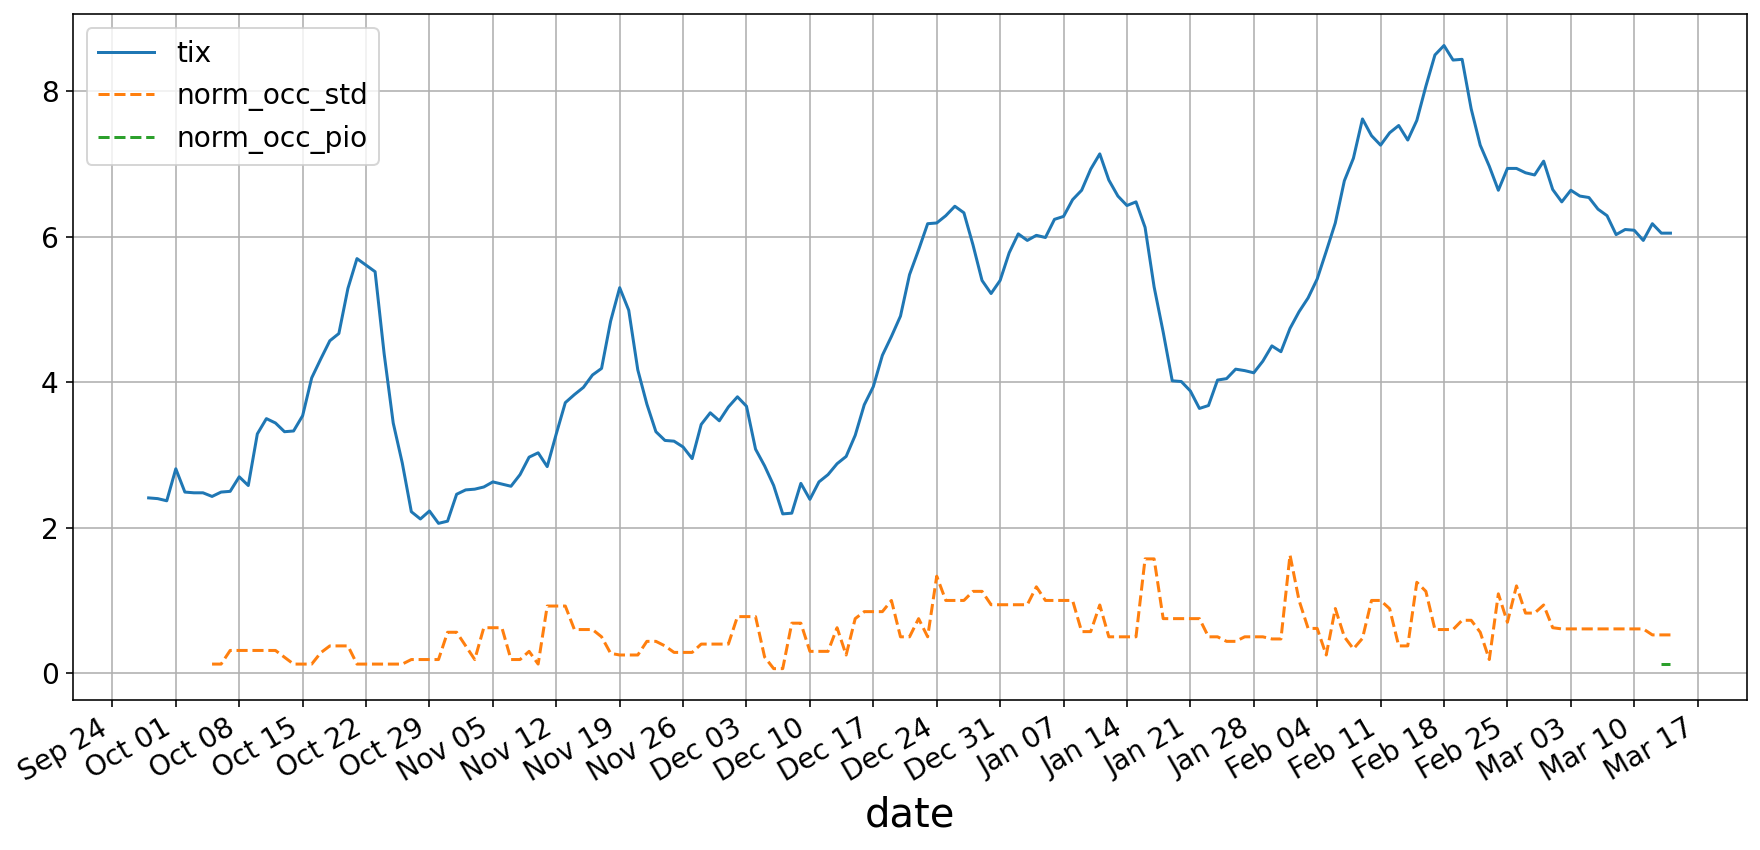

In [28]:
show_raw_and_prices(time_series)

In [29]:
time_series = time_series[['tix', 'norm_occ_std', 'norm_occ_pio']].fillna(0)

In [30]:
time_series['tix_mean'] = time_series['tix'].rolling(window=4).mean().bfill()
time_series['d_tix']=time_series['tix'].diff()
time_series.fillna(0)

,tix,norm_occ_std,norm_occ_pio,tix_mean,d_tix
date,,,,,
2019-09-28,2.41,0.000000,0.000,2.4975,0.00
2019-09-29,2.40,0.000000,0.000,2.4975,-0.01
2019-09-30,2.37,0.000000,0.000,2.4975,-0.03
2019-10-01,2.81,0.000000,0.000,2.4975,0.44
2019-10-02,2.49,0.000000,0.000,2.5175,-0.32
...,...,...,...,...,...
2020-03-10,6.09,0.608696,0.000,6.1275,-0.01
2020-03-11,5.95,0.608696,0.000,6.0425,-0.14
2020-03-12,6.18,0.526316,0.000,6.0800,0.23


In [31]:
from pandas.plotting import lag_plot

import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

plt.ion()

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14


In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class Horizonizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[], windows=[], drop_t0=True):
        self.windows = windows
        self.columns = columns
        self.drop_t0 = drop_t0
        assert len(columns) == len(windows), 'windows and columns are not same length'
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):    
        for c in range(len(self.columns)):
            subdf_cols = []
            series = X[self.columns[c]]
            for i in range(self.windows[c]):
                subdf_cols.append(self.columns[c] + '_t-' + str(i))

            subdf = pd.DataFrame(columns = subdf_cols)
            
            for i in range(len(series)):
                if i < self.windows[c]:
                    subdf.loc[i] = [series[i-j] for j in range(i+1)] + [None for k in range(1, self.windows[c]-i)]
                else:
                    subdf.loc[i] = [series[i-j] for j in range(self.windows[c])]
                    
            if len(X.index) > 0:
                subdf.set_index(X.index, inplace=True)
            
            if self.drop_t0:
                subdf = subdf.drop(self.columns[c] + '_t-' + str(0), axis=1)
                X = X.drop(self.columns[c], axis=1)
            X = pd.concat([X, subdf], axis=1)
            
        return X

In [33]:
from sklearn.linear_model import LinearRegression
from datetime import datetime
from datetime import timedelta
class Forecaster(BaseEstimator, TransformerMixin):
    def __init__(self, forecast_len=14, method=LinearRegression):
        self.forecast_len = forecast_len
        self.method = method
        self.forecast_models = []
        
    def fit(self, X, y=None):
        self.y = y.copy()
        for i in range(self.forecast_len):
            lin_reg = self.method()
            lin_reg.fit(X[:-(i+1)],y.shift(-1*(i+1))[:-(i+1)])
            
            self.forecast_models.append(lin_reg)
        return self
    
    def transform(self, X):
        return X
        
    def forecast(self, X):
        columns = []
        index = []
        date = X.index[-1]
        for i in range(self.forecast_len):
            columns.append("fore_"+str(i+1))
            index.append(date+ timedelta(days=i+1))
        
        forecast = pd.DataFrame(index = index, columns=columns)
        
        data = X.iloc[-1].values.reshape(1,-1)
        
        col = [model.predict(data) for model in self.forecast_models]
        
        return pd.Series(col, index=index)

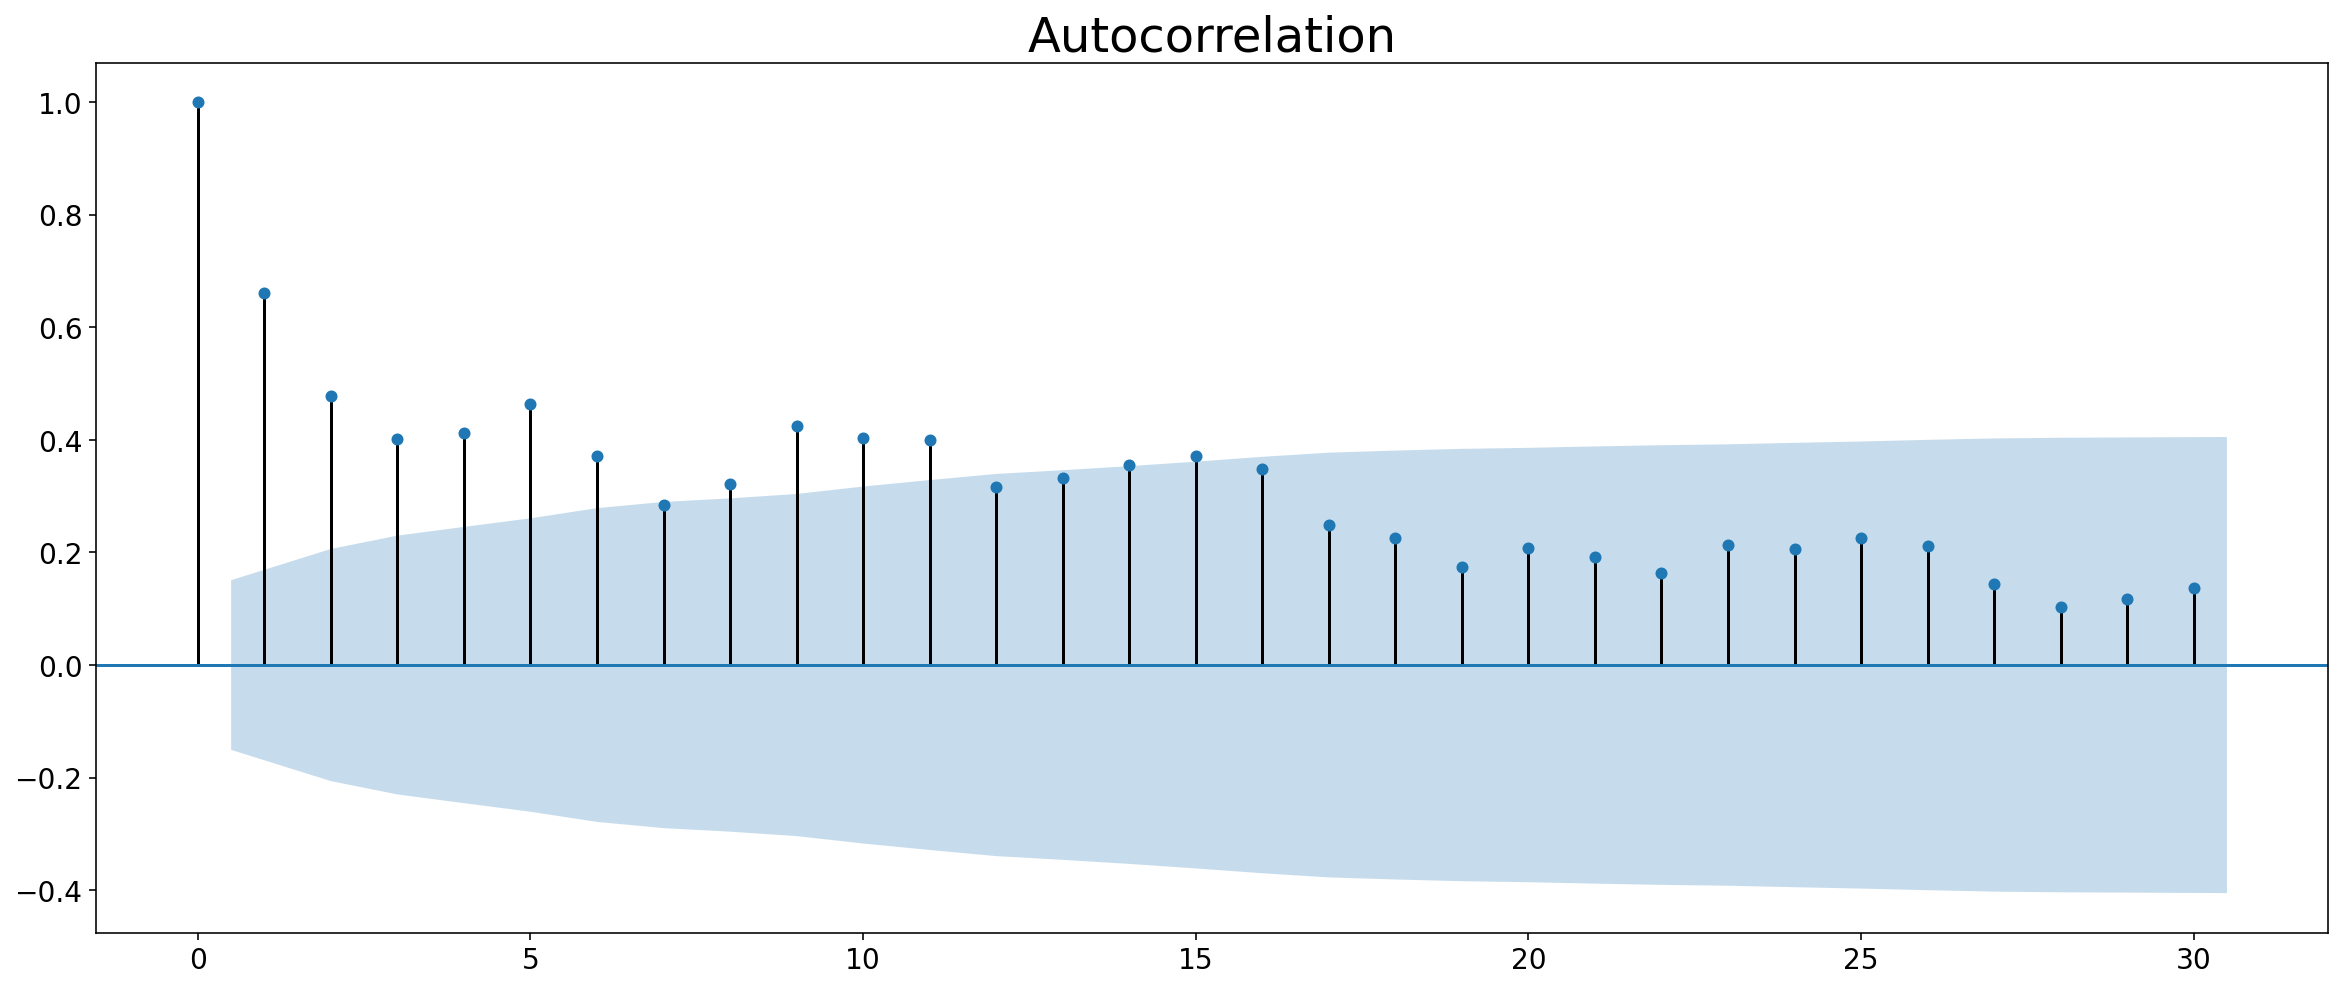

In [34]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(time_series['norm_occ_std'], lags=30)
plt.show()

In [35]:
horizon_pipeline = Horizonizer( columns=['d_tix', 'norm_occ_std', 'norm_occ_pio'], windows=[3,3,3])
df = horizon_pipeline.transform(time_series).bfill()

In [68]:
from datetime import date
start_idx = date(2020,2, 12)
X, y = df.copy().drop('tix', axis=1), df['tix']

In [69]:
forecaster = Forecaster(forecast_len=14)
forecaster.fit(X[:start_idx],y[:start_idx])

Forecaster(forecast_len=14,
           method=<class 'sklearn.linear_model._base.LinearRegression'>)

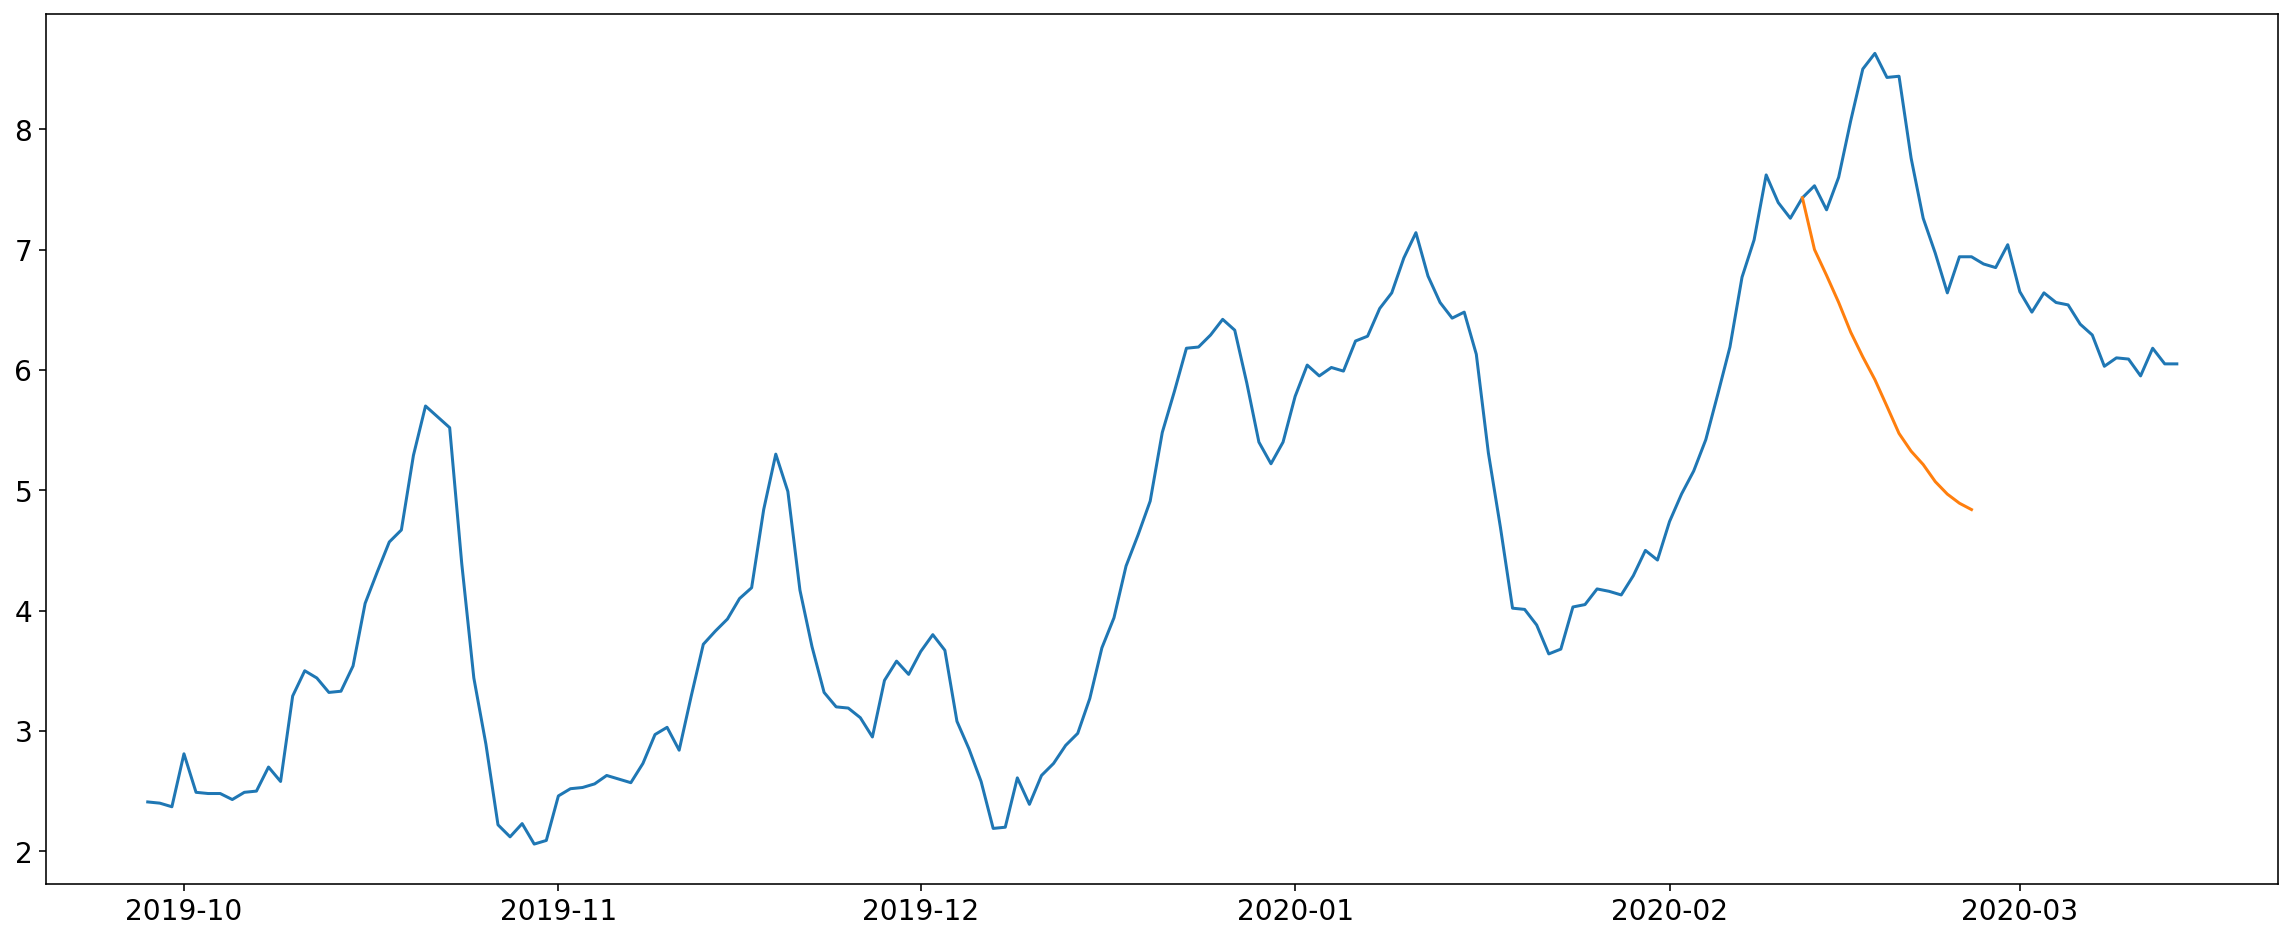

In [70]:
plt.plot(y)
forcast = forecaster.forecast(X[:start_idx])
plt.plot(pd.concat([y.copy().loc[[start_idx]], forcast]))